In [1]:
# 2枚の異なるfocus画像から奥行きを推定するプログラム
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# from tqdm import tqdm  #コマンドラインで実行するとき
from tqdm.notebook import tqdm  # jupyter で実行するとき
from models import RESNETLIKE, MyModel, MyModel_shallow

In [2]:
# リソースの指定（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# モデル・損失関数・最適化アルゴリスムの設定
LOAD_WEIGHT = True
model = MyModel(channels=2)

if LOAD_WEIGHT == True:
    # 学習済みモデルのロード
    path_saved_model = "./saved_model_Mymodel"
    model.load_state_dict(torch.load(path_saved_model))
    model.eval()

model = model.to(device)
model.eval()

MyModel(
  (conv1): Conv2d(2, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (bn64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [4]:
# 画像ペアから奥行きを推定するdataloader
class DepthEstimateData(torch.utils.data.Dataset):
    # FILEはデータが入っていたファイル、imsize = 画像サイズ、psize = パッチサイズ
    def __init__(self, IMGFILES, imsize, psize, channels, transforms):
        self.psize = psize
        self.channels = channels
        self.transforms = transforms
        
        # load file
        for fi in IMGFILES:
            img = Image.open(fi)
            img = img.convert('L')
            img = np.array(img).astype('float32')
            imgs.append(img)

        img = np.stack(imgs,axis=2)
        self.patch = []
        self.loc = []

        self.width = imsize[0]
        self.height = imsize[1]

        # 何ピクセルごとに推定するか? (高速化)
        self.STEP = 5
        
        for y in range(0,self.height-psize,self.STEP):
            for x in range(0,self.width-psize,self.STEP):
                patch = img[y:(y+psize),x:(x+psize)]
                self.patch.append(patch)
                self.loc.append([x,y])
    
    def __len__(self):
        return len(self.patch)

    def __getitem__(self, index):
        return self.transforms(self.patch[index]), self.loc[index]

In [5]:
# 対象となる画像データを読み出す (2 files)
files = ["202409191257/00450.bmp", "202409191257/00499.bmp"]
imgs = []
psize = 65
width = 1600
height = 1200

trans = transforms.Compose([
    transforms.ToTensor()
])

dataset = DepthEstimateData(IMGFILES=files, imsize=[width,height], psize=psize, channels=2, transforms=trans) 
# データローダーの作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)

In [7]:
outputs = []

for data,loc in dataloader:
    data = data.to(device)
    output = model(data).detach().cpu().numpy()
    outputs.append(output)

(array([4.000e+00, 1.000e+01, 3.200e+01, 7.800e+01, 1.100e+02, 1.680e+02,
        2.250e+02, 3.100e+02, 4.610e+02, 7.740e+02, 1.667e+03, 3.785e+03,
        6.791e+03, 9.375e+03, 9.882e+03, 8.034e+03, 5.005e+03, 2.614e+03,
        1.162e+03, 5.530e+02, 4.370e+02, 3.980e+02, 3.620e+02, 3.040e+02,
        2.840e+02, 2.740e+02, 2.430e+02, 2.530e+02, 2.690e+02, 2.530e+02,
        2.530e+02, 2.400e+02, 2.210e+02, 2.210e+02, 2.010e+02, 1.890e+02,
        1.980e+02, 1.810e+02, 1.850e+02, 1.770e+02, 1.790e+02, 1.770e+02,
        1.590e+02, 1.490e+02, 1.650e+02, 1.570e+02, 1.550e+02, 1.620e+02,
        1.710e+02, 1.710e+02, 1.730e+02, 1.760e+02, 2.140e+02, 2.210e+02,
        2.220e+02, 3.020e+02, 2.700e+02, 3.190e+02, 3.430e+02, 3.680e+02,
        4.180e+02, 4.390e+02, 4.360e+02, 4.830e+02, 5.260e+02, 4.760e+02,
        5.360e+02, 5.770e+02, 5.220e+02, 4.030e+02, 2.960e+02, 2.560e+02,
        1.790e+02, 1.260e+02, 1.300e+02, 1.190e+02, 1.060e+02, 1.020e+02,
        1.040e+02, 1.130e+02, 1.480e+0

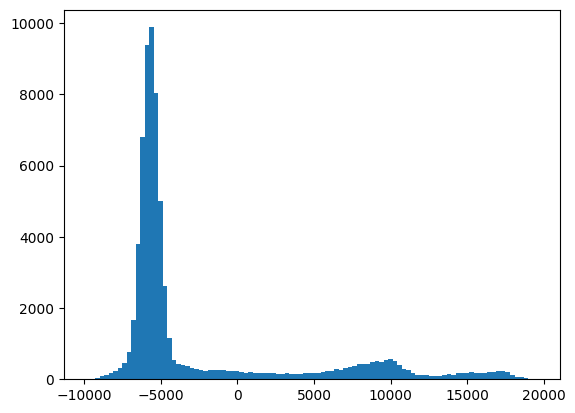

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

result = np.concatenate(outputs)
plt.hist(result, bins=100)

(69689, 1)


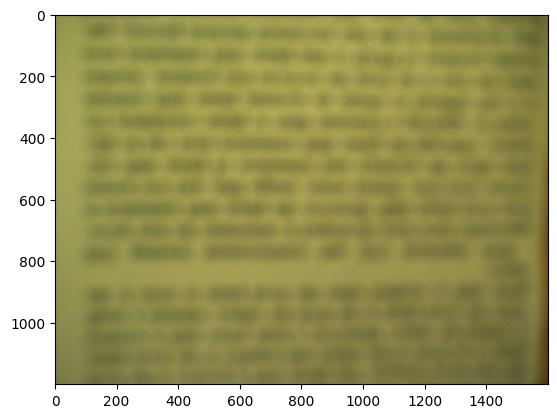

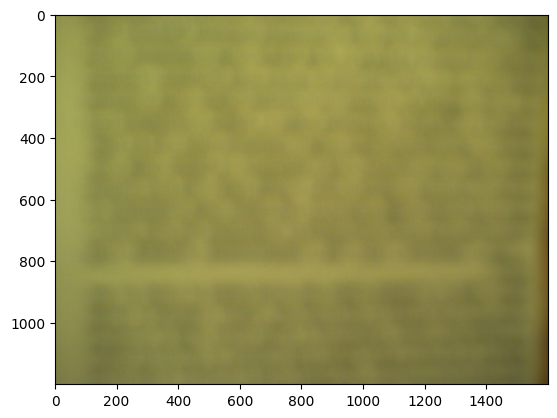

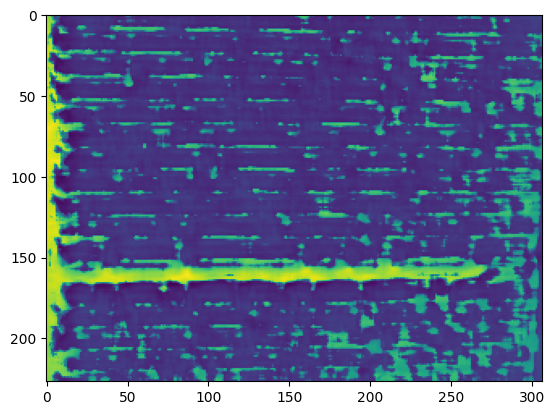

In [9]:
print(result.shape)
ws = int((width - psize)/5)
hs = int((height - psize)/5)
result2 = result.reshape([hs,ws])

plt.imshow(Image.open(files[0]))
plt.show()
plt.imshow(Image.open(files[1]))
plt.show()
plt.imshow(result2)
plt.show()